# Environment

In [28]:
import pandas as pd
import yaml
import os
import sys
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
ENDO_COLOR = "#4CAF50"  # green
EXO_COLOR = "#FFEB3B"  # yellow

WORKING_DIR = "D:/Github/SRF_MeCP2_cut_tag"
BASE_DIR = f"{WORKING_DIR}/iterative_alternative/results/no_dedup/cpg_enrichment/neu_vs_nsc_endo"

ENRICHMENT_FILE = f"{BASE_DIR}/cpg_enrichment_parallel.csv"
print(ENRICHMENT_FILE)

OUTPUT_LISTS_PATH = f"{BASE_DIR}/lists"
print(OUTPUT_LISTS_PATH)
os.makedirs(OUTPUT_LISTS_PATH, exist_ok=True)

# Set pandas display options to show all columns without wrapping
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide DataFrames
pd.set_option('display.max_colwidth', None) # Don't truncate column contents

sys.path.append(f"{WORKING_DIR}/iterative_alternative/code7_cpg_enrichment")
try:
    import functions
    importlib.reload(functions)
    from functions import *
except ModuleNotFoundError:
    print("Warning: Could not import functions module. Make sure functions.py exists in the code7_cpg_enrichment directory.")


D:/Github/SRF_MeCP2_cut_tag/iterative_alternative/results/no_dedup/cpg_enrichment/neu_vs_nsc_endo/cpg_enrichment_parallel.csv
D:/Github/SRF_MeCP2_cut_tag/iterative_alternative/results/no_dedup/cpg_enrichment/neu_vs_nsc_endo/lists


In [30]:
def plot_enrichment_distribution_mod(df_list, labels, factor=3, title=None, 
                                     colors=None, alpha=0.7, enrichment_lines=[2],
                                     color1="#f04c3c", color2="#201cf4"):
    """
    Create overlaid histograms of enrichment values for regions bound by both Exo and Endo.
    
    Args:
        df_list: List of DataFrames containing enrichment values
        labels: List of labels for each DataFrame
        factor: Factor to multiply IQR by for determining plot range (default=3)
        title: Optional custom title for the plot
        colors: List of colors for each histogram (default: [color1, color2])
        alpha: Transparency value for histograms (default: 0.5)
        enrichment_lines: List of enrichment values at which to draw vertical lines (default: [1])
        color1: Color for NEU data (default: "#f04c3c")
        color2: Color for NSC data (default: "#201cf4")
    """
    plt.figure(figsize=(10, 6))

    # Determine global range based on all data distributions
    all_enrichments = []
    for df in df_list:
        all_enrichments.extend(df['enrichment'])
    
    q1 = np.quantile(all_enrichments, 0.25)
    q3 = np.quantile(all_enrichments, 0.75)
    iqr = q3 - q1
    range_min = max(0, q1 - factor * iqr)  # Don't go below 0 for enrichment
    range_max = q3 + factor * iqr

    if colors is None:
        colors = [color1, color2]  # Assign default colors


    # Plot overlaid histograms
    for i, df in enumerate(df_list):
        plt.hist(df['enrichment'], bins=50, alpha=alpha,
                 label=labels[i], density=False, range=(range_min, range_max), color=colors[i])

    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Improve axis labels and title
    plt.xlabel('Enrichment Score', fontsize=12)
    plt.ylabel('Number of Regions', fontsize=12)
    if title is None:
        title = 'Distribution of Enrichment Values\nin Regions Bound by Both Exo and Endo'
    else:
        title = f'Distribution of Enrichment Values\nin Regions Bound by Both Exo and Endo\n{title}'
    plt.title(title, fontsize=14, pad=15)

    # Add vertical lines at specified enrichment values
    for enrichment_val in enrichment_lines:
        plt.axvline(x=enrichment_val, color='red', linestyle='--', linewidth=2,
                    label=f'Enrichment = {enrichment_val}')

    # Set x-axis limits based on the calculated data range
    plt.xlim(range_min, range_max)

    # Add legend with better positioning
    plt.legend(loc='upper right')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    plt.show()
    
    return range_min, range_max


# Load Data

In [31]:
# Load the CpG enrichment results
cpg_enrichment_df = pd.read_csv(ENRICHMENT_FILE)

In [32]:
# Display first few rows and basic info
print("DataFrame shape:", cpg_enrichment_df.shape)
print("\nFirst few rows:")
display(cpg_enrichment_df.head())
print("\nColumn names:")
print(cpg_enrichment_df.columns.tolist())

DataFrame shape: (14871, 24)

First few rows:


,chr,start,end,neu_signal,nsc_signal,fold_change,pvalue,binding_type,binding_type_by_peaks,significant,neu_replicates_with_signal,nsc_replicates_with_signal,neu_replicate_signals,nsc_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,neu_replicates_with_peaks,nsc_replicates_with_peaks,neu_peak_scores_by_rep,nsc_peak_scores_by_rep,region_start,region_end
0,chr1,3531624,3531843,2.845584,12.768126,0.222866,0.666667,both,nsc_only,False,2,1,"6.635254696011543,0.0,1.901497251712359","0.0,0.0,38.30437894050892",416,219,CpG:,611,0,1,NaN,5.10095,3531809,3532225
1,chr1,3670619,3671074,51.041933,13.800820,3.698471,0.100000,both,neu_only,False,3,3,"46.80457341624963,64.44004480749791,41.88117982613994","11.392776214324677,14.437202170702175,15.57248052329477",1554,455,CpG:,613,1,0,12.1862,NaN,3670786,3672340
2,chr1,3671654,3672156,51.041933,13.800820,3.698471,0.100000,both,neu_only,False,3,3,"46.80457341624963,64.44004480749791,41.88117982613994","11.392776214324677,14.437202170702175,15.57248052329477",1554,502,CpG:,613,2,0,14.2013;12.1862,NaN,3670786,3672340
3,chr1,4491701,4493673,3.953878,8.716315,0.453618,0.333333,both,nsc_only,False,2,2,"4.857184294392081,0.0,7.0044510406606335","13.231673493104822,0.0,12.917271586025462",1360,1972,CpG:,619,0,1,NaN,4.1282,4492093,4493453
4,chr1,4496947,4497608,5.056848,1.620731,3.120104,0.666667,both,neu_only,False,2,2,"12.533199566008838,0.0,2.637344861316631","1.6485985968345518,0.0,3.213593737184846",1917,661,CpG:,619,1,0,4.61906,NaN,4496686,4498603



Column names:
['chr', 'start', 'end', 'neu_signal', 'nsc_signal', 'fold_change', 'pvalue', 'binding_type', 'binding_type_by_peaks', 'significant', 'neu_replicates_with_signal', 'nsc_replicates_with_signal', 'neu_replicate_signals', 'nsc_replicate_signals', 'region_length', 'cpg_length', 'cpg_score', 'cpg_name', 'neu_replicates_with_peaks', 'nsc_replicates_with_peaks', 'neu_peak_scores_by_rep', 'nsc_peak_scores_by_rep', 'region_start', 'region_end']


In [33]:
cpg_enrichment_df = cpg_enrichment_df.rename(columns={'fold_change': 'enrichment'})

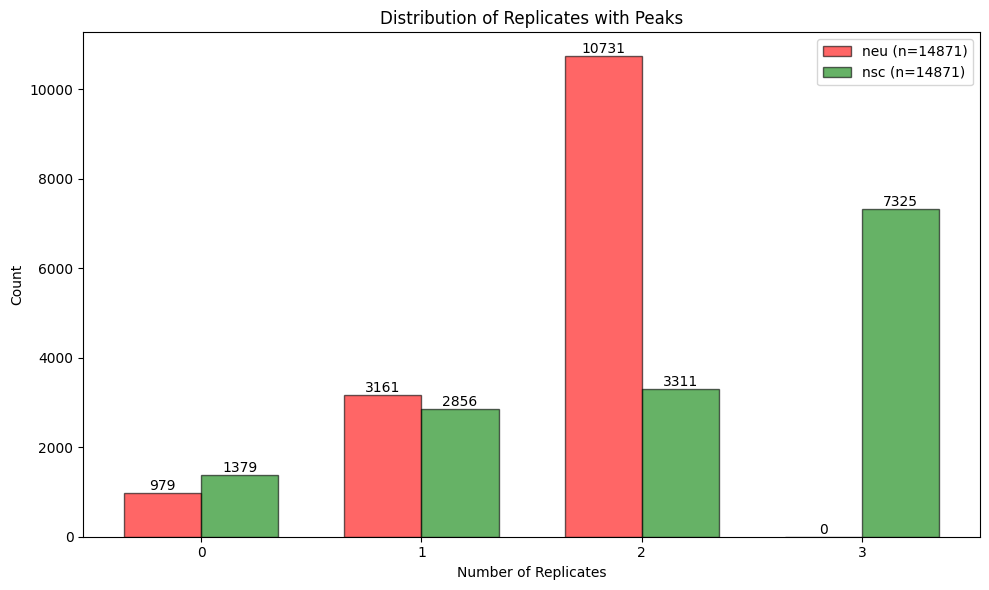

In [34]:
# Create single plot
plt.figure(figsize=(10, 6))

# Get data for plotting
x = np.arange(4)  # 0 through 3 replicates
neu_counts = [len(cpg_enrichment_df[cpg_enrichment_df['neu_replicates_with_peaks'] == i]) for i in range(4)]
nsc_counts = [len(cpg_enrichment_df[cpg_enrichment_df['nsc_replicates_with_peaks'] == i]) for i in range(4)]

# Plot bars side by side
width = 0.35
plt.bar(x - width/2, neu_counts, width, label=f'neu (n={sum(neu_counts)})', color='red', alpha=0.6, edgecolor='black')
plt.bar(x + width/2, nsc_counts, width, label=f'nsc (n={sum(nsc_counts)})', color='green', alpha=0.6, edgecolor='black')

# Add value labels on top of each bar
for i in range(len(x)):
    plt.text(x[i] - width/2, neu_counts[i], str(neu_counts[i]), 
             ha='center', va='bottom')
    plt.text(x[i] + width/2, nsc_counts[i], str(nsc_counts[i]),
             ha='center', va='bottom')

plt.title('Distribution of Replicates with Peaks')
plt.xlabel('Number of Replicates')
plt.ylabel('Count')
plt.xticks(x)
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Sort the DataFrame by enrichment value in descending order
cpg_enrichment_df_sorted = cpg_enrichment_df.sort_values(by='enrichment', ascending=False)

# Split data based on binding type

## By signal value

Non zero signal in minumum 2 replicates

In [36]:
# Split data based on binding type
neu_only_df_by_signal = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type'] == 'neu_only']
nsc_only_df_by_signal = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type'] == 'nsc_only'] 
both_df_by_signal = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type'] == 'both']

# Print sizes of each group
print(f"Number of CpG islands bound by neu only: {len(neu_only_df_by_signal)}")
print(f"Number of CpG islands bound by nsc only: {len(nsc_only_df_by_signal)}")
print(f"Number of CpG islands bound by both: {len(both_df_by_signal)}")

endo_neu_only_df_by_signal = neu_only_df_by_signal
endo_nsc_only_df_by_signal = nsc_only_df_by_signal
endo_both_df_by_signal = both_df_by_signal


Number of CpG islands bound by neu only: 128
Number of CpG islands bound by nsc only: 15
Number of CpG islands bound by both: 14728


In [37]:
EXO_ENRICHMENT_FILE = 'D:/Github/SRF_MeCP2_cut_tag/iterative_alternative/results/no_dedup/cpg_enrichment/neu_vs_nsc_exo/cpg_enrichment_parallel.csv'
exo_cpg_enrichment_df = pd.read_csv(EXO_ENRICHMENT_FILE)
exo_cpg_enrichment_df = exo_cpg_enrichment_df.rename(columns={'fold_change': 'enrichment'})

# Split data based on binding type
exo_neu_only_df_by_signal = exo_cpg_enrichment_df[exo_cpg_enrichment_df['binding_type'] == 'neu_only']
exo_nsc_only_df_by_signal = exo_cpg_enrichment_df[exo_cpg_enrichment_df['binding_type'] == 'nsc_only'] 
exo_both_df_by_signal = exo_cpg_enrichment_df[exo_cpg_enrichment_df['binding_type'] == 'both']

# Print sizes of each group
print(f"Number of CpG islands bound by neu only: {len(exo_neu_only_df_by_signal)}")
print(f"Number of CpG islands bound by nsc only: {len(exo_nsc_only_df_by_signal)}")
print(f"Number of CpG islands bound by both: {len(exo_both_df_by_signal)}")


Number of CpG islands bound by neu only: 89
Number of CpG islands bound by nsc only: 25
Number of CpG islands bound by both: 15159


## By peaks number

Minimum 1 replicates with peaks

In [38]:
# Split data based on binding type
neu_only_df_by_peaks = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type_by_peaks'] == 'neu_only']
nsc_only_df_by_peaks = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type_by_peaks'] == 'nsc_only'] 
both_df_by_peaks = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type_by_peaks'] == 'both']

# Print sizes of each group
print(f"Number of CpG islands bound by neu only: {len(neu_only_df_by_peaks)}")
print(f"Number of CpG islands bound by nsc only: {len(nsc_only_df_by_peaks)}")
print(f"Number of CpG islands bound by both: {len(both_df_by_peaks)}")


Number of CpG islands bound by neu only: 1379
Number of CpG islands bound by nsc only: 979
Number of CpG islands bound by both: 12513


# Data analysis

## Enrichment distribution by different signal type

In [39]:
endo_both_df_by_signal.head()

,chr,start,end,neu_signal,nsc_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,neu_replicates_with_signal,nsc_replicates_with_signal,neu_replicate_signals,nsc_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,neu_replicates_with_peaks,nsc_replicates_with_peaks,neu_peak_scores_by_rep,nsc_peak_scores_by_rep,region_start,region_end
9816,chr4,140034425,140034657,20.495094,0.006735,3043.026704,0.5,both,both,False,3,1,"35.188613834425084,13.608487163663918,12.688179579448187","0.0,0.0,0.02020530431294423",1301,232,CpG:,1653,1,2,12.1323,5.61033;3.11511,140034373,140035674
4616,chr15,76002957,76004677,23.531489,0.008887,2647.920164,0.5,both,neu_only,False,3,1,"22.412463105958082,12.290410596748877,35.891593398718996","0.0,0.0,0.026660345751663733",580,1720,CpG:,1164,1,0,6.57645,NaN,76003305,76003885
120,chr1,37875331,37875824,13.078606,0.006885,1899.625849,0.5,both,both,False,3,1,"10.308551995285795,23.44580811978785,5.481458635973441","0.0,0.020654498237319005,0.0",1705,493,CpG:,873,1,2,4.20458,3.25313;5.92257,37874909,37876614
5967,chr17,47672400,47672829,44.641029,0.045789,974.930449,0.5,both,neu_only,False,3,1,"15.480388649473799,108.23670611280076,10.20599128236162","0.0,0.13736681025078956,0.0",235,429,CpG:,948,1,0,7.14251,NaN,47672467,47672702
995,chr10,50900711,50901152,15.445646,0.016971,910.100900,0.5,both,neu_only,False,3,1,"15.546214704568676,29.684237662078328,1.1064859107280283","0.05091406706440656,0.0,0.0",519,441,CpG:,973,1,0,9.94573,NaN,50900611,50901130


In [40]:
exo_both_df_by_signal.head()

,chr,start,end,neu_signal,nsc_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,neu_replicates_with_signal,nsc_replicates_with_signal,neu_replicate_signals,nsc_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,neu_replicates_with_peaks,nsc_replicates_with_peaks,neu_peak_scores_by_rep,nsc_peak_scores_by_rep,region_start,region_end
0,chr1,3670619,3671074,44.531091,13.042663,3.414264,0.100000,both,both,False,3,3,"43.611977159783706,52.05083147360805,37.93046437749823","8.58457662022296,18.074157164901866,12.46925556753564",2159,455,CpG:,613,3,1,6.08946;8.05807;5.49517,6.06037,3670396,3672555
1,chr1,3671654,3672156,44.531091,13.042663,3.414264,0.100000,both,both,False,3,3,"43.611977159783706,52.05083147360805,37.93046437749823","8.58457662022296,18.074157164901866,12.46925556753564",2159,502,CpG:,613,3,2,6.08946;8.05807;5.49517,5.54931;6.06037,3670396,3672555
2,chr1,4491701,4493673,3.420399,28.438007,0.120276,0.333333,both,nsc_only,False,2,2,"2.429280403817054,0.0,7.831916790197392","44.398371658702885,0.0,40.91564872477314",404,1972,CpG:,619,0,2,NaN,6.0982;5.8282,4492305,4492709
3,chr1,4496947,4497608,10.043227,4.446822,2.258518,1.000000,both,neu_only,False,2,1,"24.89710185653509,0.0,5.232580183232011","0.0,0.0,13.340464833168392",1119,661,CpG:,619,1,0,3.0083,NaN,4496514,4497633
4,chr1,4571641,4572075,18.511282,25.026296,0.739673,0.700000,both,both,False,3,3,"13.692992781864778,18.217554917468977,23.623298807605227","31.500924768035347,13.556918122386204,30.021045078151403",786,434,CpG:,619,3,3,3.91321;3.39512;3.76449,4.35039;6.82732;3.40697,4571438,4572224


In [41]:
print("Summary statistics of enrichment values selected by signal:")
print(both_df_by_signal['enrichment'].describe())

print("\nSummary statistics of enrichment values selected by peaks:")
print(both_df_by_peaks['enrichment'].describe())

Summary statistics of enrichment values selected by signal:
count    14728.000000
mean         3.582693
std         40.216964
min          0.017629
25%          1.239067
50%          1.835131
75%          2.725572
max       3043.026704
Name: enrichment, dtype: float64

Summary statistics of enrichment values selected by peaks:
count    1.251300e+04
mean              inf
std               NaN
min      8.017512e-02
25%      1.278375e+00
50%      1.852896e+00
75%      2.672085e+00
max               inf
Name: enrichment, dtype: float64


d:\Programs\miniforge3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


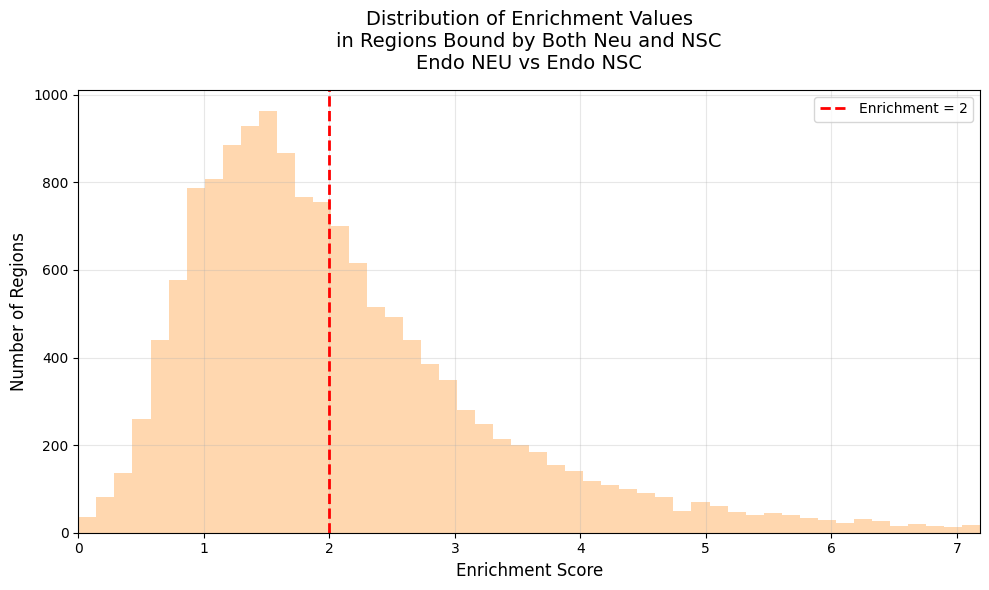

In [42]:
range_min_signal, range_max_signal = plot_enrichment_distribution_neu_vs_nsc(endo_both_df_by_signal, title="Endo NEU vs Endo NSC", color="#FFC78E")

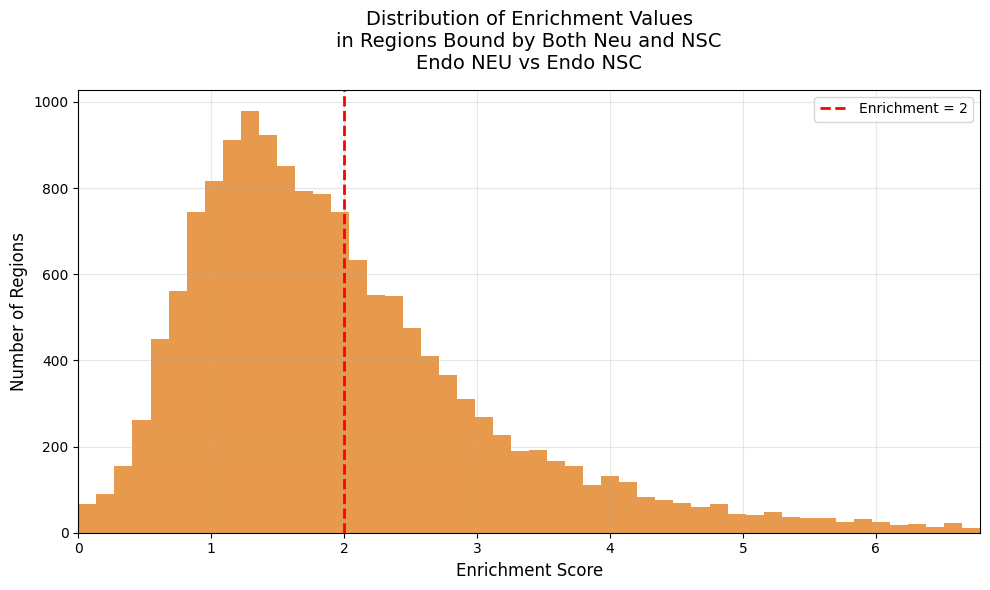

In [43]:
range_min_signal, range_max_signal = plot_enrichment_distribution_neu_vs_nsc(exo_both_df_by_signal, title="Endo NEU vs Endo NSC", color="#DD6F01")

## Compare NEU with NSC - Exo vs Endo Enrichement

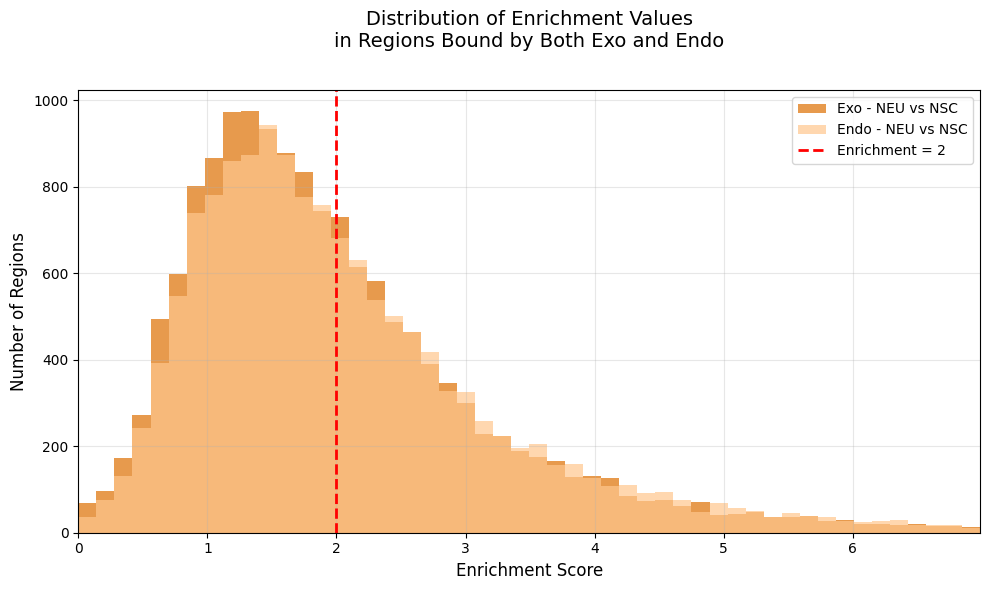

In [44]:
range_min_signal, range_max_signal = plot_enrichment_distribution_mod([exo_both_df_by_signal, endo_both_df_by_signal], 
                                                                     labels=["Exo - NEU vs NSC", "Endo - NEU vs NSC"], 
                                                                     color1="#DD6F01", color2="#FFC78E",
                                                                     title="")

In [45]:
both_df_by_signal.head()


,chr,start,end,neu_signal,nsc_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,neu_replicates_with_signal,nsc_replicates_with_signal,neu_replicate_signals,nsc_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,neu_replicates_with_peaks,nsc_replicates_with_peaks,neu_peak_scores_by_rep,nsc_peak_scores_by_rep,region_start,region_end
9816,chr4,140034425,140034657,20.495094,0.006735,3043.026704,0.5,both,both,False,3,1,"35.188613834425084,13.608487163663918,12.688179579448187","0.0,0.0,0.02020530431294423",1301,232,CpG:,1653,1,2,12.1323,5.61033;3.11511,140034373,140035674
4616,chr15,76002957,76004677,23.531489,0.008887,2647.920164,0.5,both,neu_only,False,3,1,"22.412463105958082,12.290410596748877,35.891593398718996","0.0,0.0,0.026660345751663733",580,1720,CpG:,1164,1,0,6.57645,NaN,76003305,76003885
120,chr1,37875331,37875824,13.078606,0.006885,1899.625849,0.5,both,both,False,3,1,"10.308551995285795,23.44580811978785,5.481458635973441","0.0,0.020654498237319005,0.0",1705,493,CpG:,873,1,2,4.20458,3.25313;5.92257,37874909,37876614
5967,chr17,47672400,47672829,44.641029,0.045789,974.930449,0.5,both,neu_only,False,3,1,"15.480388649473799,108.23670611280076,10.20599128236162","0.0,0.13736681025078956,0.0",235,429,CpG:,948,1,0,7.14251,NaN,47672467,47672702
995,chr10,50900711,50901152,15.445646,0.016971,910.100900,0.5,both,neu_only,False,3,1,"15.546214704568676,29.684237662078328,1.1064859107280283","0.05091406706440656,0.0,0.0",519,441,CpG:,973,1,0,9.94573,NaN,50900611,50901130


## Both: enrichment outliers

In [46]:
outliers_df_signal = both_df_by_signal[both_df_by_signal['enrichment'] > range_max_signal].copy()
print(f"\nNumber of outliers selected by signal(enrichment > {range_max_signal}):", len(outliers_df_signal))

# outliers_df_peaks = both_df_by_peaks[both_df_by_peaks['enrichment'] > range_max_peaks].copy()
# print(f"\nNumber of outliers selected by peaks(enrichment > {range_max_peaks}):", len(outliers_df_peaks))


Number of outliers selected by signal(enrichment > 6.986649490847054): 462


In [47]:
outliers_df_signal.head()

,chr,start,end,neu_signal,nsc_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,neu_replicates_with_signal,nsc_replicates_with_signal,neu_replicate_signals,nsc_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,neu_replicates_with_peaks,nsc_replicates_with_peaks,neu_peak_scores_by_rep,nsc_peak_scores_by_rep,region_start,region_end
9816,chr4,140034425,140034657,20.495094,0.006735,3043.026704,0.5,both,both,False,3,1,"35.188613834425084,13.608487163663918,12.688179579448187","0.0,0.0,0.02020530431294423",1301,232,CpG:,1653,1,2,12.1323,5.61033;3.11511,140034373,140035674
4616,chr15,76002957,76004677,23.531489,0.008887,2647.920164,0.5,both,neu_only,False,3,1,"22.412463105958082,12.290410596748877,35.891593398718996","0.0,0.0,0.026660345751663733",580,1720,CpG:,1164,1,0,6.57645,NaN,76003305,76003885
120,chr1,37875331,37875824,13.078606,0.006885,1899.625849,0.5,both,both,False,3,1,"10.308551995285795,23.44580811978785,5.481458635973441","0.0,0.020654498237319005,0.0",1705,493,CpG:,873,1,2,4.20458,3.25313;5.92257,37874909,37876614
5967,chr17,47672400,47672829,44.641029,0.045789,974.930449,0.5,both,neu_only,False,3,1,"15.480388649473799,108.23670611280076,10.20599128236162","0.0,0.13736681025078956,0.0",235,429,CpG:,948,1,0,7.14251,NaN,47672467,47672702
995,chr10,50900711,50901152,15.445646,0.016971,910.100900,0.5,both,neu_only,False,3,1,"15.546214704568676,29.684237662078328,1.1064859107280283","0.05091406706440656,0.0,0.0",519,441,CpG:,973,1,0,9.94573,NaN,50900611,50901130


In [48]:
print_outlier_groups(outliers_df_signal, "signal")


First 5 outliers selected by signal:
chr4:140,034,425-140,034,657                      enrichment: 3043.026703544749
chr15:76,002,957-76,004,677                       enrichment: 2647.9201642394496
chr1:37,875,331-37,875,824                        enrichment: 1899.625849063471
chr17:47,672,400-47,672,829                       enrichment: 974.9304493577
chr10:50,900,711-50,901,152                       enrichment: 910.100900381

Middle 5 outliers selected by signal:
chr9:83,447,779-83,447,992                        enrichment: 11.216578067781844
chr19:59,469,037-59,469,305                       enrichment: 11.1843486210917
chr15:101,052,673-101,054,340                     enrichment: 11.12308549770771
chr7:79,742,694-79,743,167                        enrichment: 11.11761159799184
chr18:12,973,303-12,973,796                       enrichment: 11.088527801909189

Last 5 outliers selected by signal:
chr4:119,421,975-119,422,972                      enrichment: 7.013432946458726
chr2:119,89

In [49]:
n_rows = len(outliers_df_signal)

print("\nFirst 5 outliers selected by signal:")
for _, row in outliers_df_signal[:5].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + f"enrichment: {row['enrichment']}")

if n_rows > 10:
    mid_start = n_rows//2 - 2
    print("\nMiddle 5 outliers selected by signal:")
    for _, row in outliers_df_signal[mid_start:mid_start+5].iterrows():
        print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + f"enrichment: {row['enrichment']}")

print("\nLast 5 outliers selected by signal:")
for _, row in outliers_df_signal[-5:].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + f"enrichment: {row['enrichment']}")


First 5 outliers selected by signal:
chr4:140,034,425-140,034,657                      enrichment: 3043.026703544749
chr15:76,002,957-76,004,677                       enrichment: 2647.9201642394496
chr1:37,875,331-37,875,824                        enrichment: 1899.625849063471
chr17:47,672,400-47,672,829                       enrichment: 974.9304493577
chr10:50,900,711-50,901,152                       enrichment: 910.100900381

Middle 5 outliers selected by signal:
chr9:83,447,779-83,447,992                        enrichment: 11.216578067781844
chr19:59,469,037-59,469,305                       enrichment: 11.1843486210917
chr15:101,052,673-101,054,340                     enrichment: 11.12308549770771
chr7:79,742,694-79,743,167                        enrichment: 11.11761159799184
chr18:12,973,303-12,973,796                       enrichment: 11.088527801909189

Last 5 outliers selected by signal:
chr4:119,421,975-119,422,972                      enrichment: 7.013432946458726
chr2:119,89

In [50]:
# print_outlier_groups(outliers_df_peaks, "peaks")

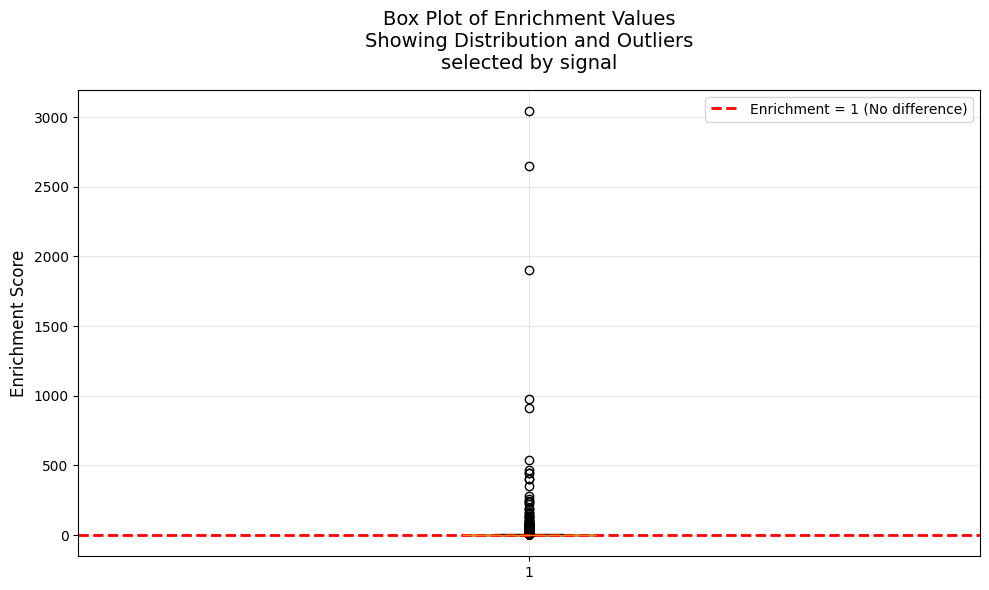

In [51]:
# plot_enrichment_boxplot(both_df_by_peaks, title="selected by peaks")
plot_enrichment_boxplot(both_df_by_signal, title="selected by signal")

In [52]:
outliers_df_signal["nsc_replicates_with_peaks"].value_counts()

signal_nsc_zero_peaks  = outliers_df_signal[outliers_df_signal["nsc_replicates_with_peaks"] == 0]
signal_nsc_one_peaks   = outliers_df_signal[outliers_df_signal["nsc_replicates_with_peaks"] == 1]
signal_nsc_two_peaks   = outliers_df_signal[outliers_df_signal["nsc_replicates_with_peaks"] == 2]
signal_nsc_three_peaks = outliers_df_signal[outliers_df_signal["nsc_replicates_with_peaks"] == 3]

# outliers_df_peaks["nsc_replicates_with_peaks"].value_counts()

# peaks_nsc_zero_peaks  = outliers_df_peaks[outliers_df_peaks["nsc_replicates_with_peaks"] == 0]
# peaks_nsc_one_peaks   = outliers_df_peaks[outliers_df_peaks["nsc_replicates_with_peaks"] == 1]
# peaks_nsc_two_peaks   = outliers_df_peaks[outliers_df_peaks["nsc_replicates_with_peaks"] == 2]
# peaks_nsc_three_peaks = outliers_df_peaks[outliers_df_peaks["nsc_replicates_with_peaks"] == 3]

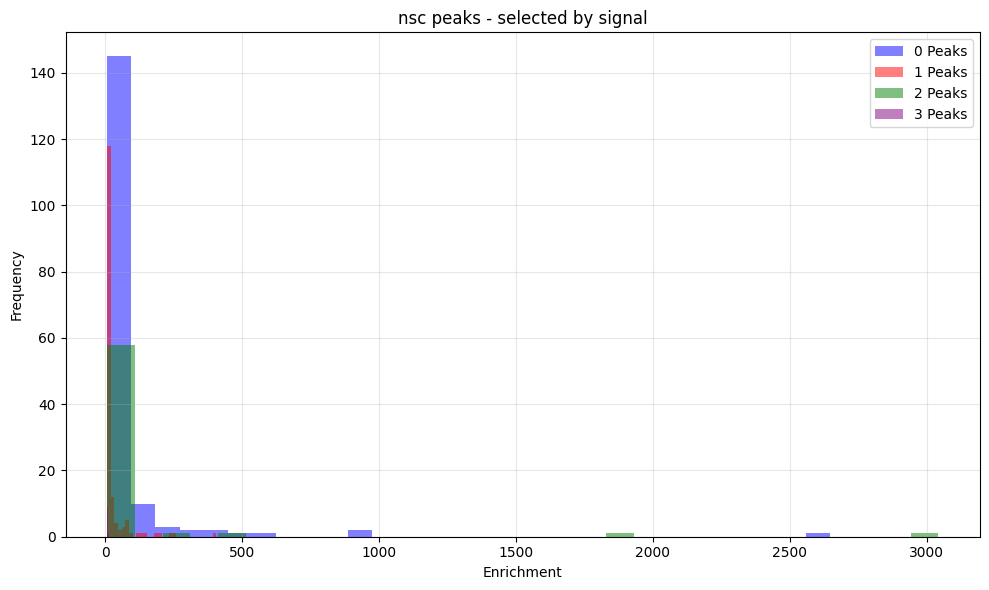

In [53]:
# Classify and plot for signal and peaks outliers
peaks_zero_peaks_signal, peaks_one_peaks_signal, peaks_two_peaks_signal, peaks_three_peaks_signal = plot_by_peaks(outliers_df_signal, peaks_column='nsc_replicates_with_peaks', title="nsc peaks - selected by signal")
# peaks_zero_peaks_peaks, peaks_one_peaks_peaks, peaks_two_peaks_peaks, peaks_three_peaks_peaks = plot_by_peaks(outliers_df_peaks, peaks_column='nsc_replicates_with_peaks', title="nsc peaks - selected by peaks")

In [54]:
# print_outlier_groups(peaks_two_peaks_peaks, "peaks")

In [55]:
print_outlier_groups(peaks_two_peaks_signal, "signal")


First 5 outliers selected by signal:
chr4:140,034,425-140,034,657                      enrichment: 3043.026703544749
chr1:37,875,331-37,875,824                        enrichment: 1899.625849063471
chr7:12,803,403-12,803,766                        enrichment: 443.7191411587498
chr13:46,771,211-46,771,472                       enrichment: 234.4730463826956
chr5:24,164,871-24,165,339                        enrichment: 48.43033180387787

Middle 5 outliers selected by signal:
chr19:6,831,101-6,831,499                         enrichment: 13.967746858925548
chr19:6,829,958-6,830,465                         enrichment: 13.967746858925548
chr8:122,630,710-122,630,962                      enrichment: 12.717184058346636
chr3:127,695,407-127,695,763                      enrichment: 11.351814503294849
chr19:59,469,037-59,469,305                       enrichment: 11.1843486210917

Last 5 outliers selected by signal:
chr8:119,840,183-119,840,679                      enrichment: 7.2308807673027005
ch

## Regions length distribution

### Region length - defined by the outermost peaks coordinates

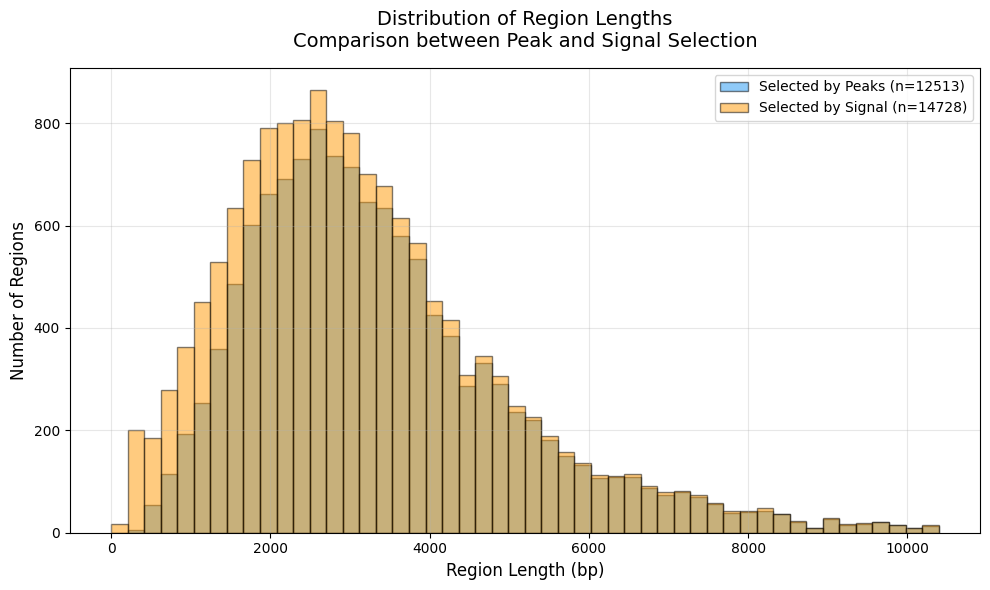

In [56]:
plot_region_length_comparison(both_df_by_peaks, both_df_by_signal, region_length_col='region_length')

In [57]:
both_df_sorted_by_region_length_signal = both_df_by_signal.sort_values(by='region_length', ascending=False)
both_df_sorted_by_region_length_signal.head()

,chr,start,end,neu_signal,nsc_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,neu_replicates_with_signal,nsc_replicates_with_signal,neu_replicate_signals,nsc_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,neu_replicates_with_peaks,nsc_replicates_with_peaks,neu_peak_scores_by_rep,nsc_peak_scores_by_rep,region_start,region_end
9903,chr4,150236643,150237472,47.675792,23.684729,2.012934,0.1,both,both,False,3,3,"37.94593123279767,60.18651302851127,44.894931360781115","32.00876582072813,18.308545432763683,20.73687613113592",19333,829,CpG:,1731,2,3,12.5768;14.1382,15.7933;7.14929;6.87428,150232224,150251557
12179,chr7,45717703,45718318,73.186502,33.712925,2.170874,0.1,both,both,False,3,3,"73.75731885911276,91.58136884385715,54.22081840728452","30.130568605794064,35.65488310846881,35.35332301937675",19242,615,CpG:,933,2,2,15.0251;10.8655,4.89628;11.8479,45700675,45719917
12174,chr7,45704790,45705154,73.403787,33.748239,2.175041,0.1,both,both,False,3,3,"73.98585911264585,91.91310823541411,54.31239324723664","30.138211381089384,35.71502853770806,35.39147714133252",19164,364,CpG:,933,2,3,22.8556;18.961,28.2728;12.7485;11.8479,45700675,45719839
12178,chr7,45714976,45715370,73.403787,33.748239,2.175041,0.1,both,both,False,3,3,"73.98585911264585,91.91310823541411,54.31239324723664","30.138211381089384,35.71502853770806,35.39147714133252",19164,394,CpG:,933,2,3,10.6149;10.8322,16.9373;6.68945;11.8479,45700675,45719839
12175,chr7,45705454,45705704,73.403787,33.748239,2.175041,0.1,both,both,False,3,3,"73.98585911264585,91.91310823541411,54.31239324723664","30.138211381089384,35.71502853770806,35.39147714133252",19164,250,CpG:,933,2,3,22.8556;18.961,28.2728;12.7485;11.8479,45700675,45719839


In [58]:
both_df_sorted_by_region_length_peaks = both_df_by_peaks.sort_values(by='region_length', ascending=False)
both_df_sorted_by_region_length_peaks.head()

,chr,start,end,neu_signal,nsc_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,neu_replicates_with_signal,nsc_replicates_with_signal,neu_replicate_signals,nsc_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,neu_replicates_with_peaks,nsc_replicates_with_peaks,neu_peak_scores_by_rep,nsc_peak_scores_by_rep,region_start,region_end
9903,chr4,150236643,150237472,47.675792,23.684729,2.012934,0.1,both,both,False,3,3,"37.94593123279767,60.18651302851127,44.894931360781115","32.00876582072813,18.308545432763683,20.73687613113592",19333,829,CpG:,1731,2,3,12.5768;14.1382,15.7933;7.14929;6.87428,150232224,150251557
12179,chr7,45717703,45718318,73.186502,33.712925,2.170874,0.1,both,both,False,3,3,"73.75731885911276,91.58136884385715,54.22081840728452","30.130568605794064,35.65488310846881,35.35332301937675",19242,615,CpG:,933,2,2,15.0251;10.8655,4.89628;11.8479,45700675,45719917
12178,chr7,45714976,45715370,73.403787,33.748239,2.175041,0.1,both,both,False,3,3,"73.98585911264585,91.91310823541411,54.31239324723664","30.138211381089384,35.71502853770806,35.39147714133252",19164,394,CpG:,933,2,3,10.6149;10.8322,16.9373;6.68945;11.8479,45700675,45719839
12174,chr7,45704790,45705154,73.403787,33.748239,2.175041,0.1,both,both,False,3,3,"73.98585911264585,91.91310823541411,54.31239324723664","30.138211381089384,35.71502853770806,35.39147714133252",19164,364,CpG:,933,2,3,22.8556;18.961,28.2728;12.7485;11.8479,45700675,45719839
12175,chr7,45705454,45705704,73.403787,33.748239,2.175041,0.1,both,both,False,3,3,"73.98585911264585,91.91310823541411,54.31239324723664","30.138211381089384,35.71502853770806,35.39147714133252",19164,250,CpG:,933,2,3,22.8556;18.961,28.2728;12.7485;11.8479,45700675,45719839


In [59]:
print_outlier_groups(both_df_sorted_by_region_length_peaks, "peaks")


First 5 outliers selected by peaks:
chr4:150,236,643-150,237,472                      enrichment: 2.012933802871601
chr7:45,717,703-45,718,318                        enrichment: 2.170873699908756
chr7:45,714,976-45,715,370                        enrichment: 2.1750405057136115
chr7:45,704,790-45,705,154                        enrichment: 2.1750405057136115
chr7:45,705,454-45,705,704                        enrichment: 2.1750405057136115

Middle 5 outliers selected by peaks:
chr12:75,735,241-75,735,934                       enrichment: 0.8479328624411606
chr17:33,629,088-33,629,329                       enrichment: 1.6216356726276169
chr4:49,059,222-49,059,927                        enrichment: 1.76953806489119
chr9:119,321,884-119,323,111                      enrichment: 2.4363513043362164
chr5:111,330,409-111,331,061                      enrichment: 1.9060242864793613

Last 5 outliers selected by peaks:
chr1:15,892,420-15,893,052                        enrichment: 0.8979481742730582
ch

In [60]:
print_outlier_groups(both_df_sorted_by_region_length_signal, "signal")


First 5 outliers selected by signal:
chr4:150,236,643-150,237,472                      enrichment: 2.012933802871601
chr7:45,717,703-45,718,318                        enrichment: 2.170873699908756
chr7:45,704,790-45,705,154                        enrichment: 2.1750405057136115
chr7:45,714,976-45,715,370                        enrichment: 2.1750405057136115
chr7:45,705,454-45,705,704                        enrichment: 2.1750405057136115

Middle 5 outliers selected by signal:
chr13:78,181,213-78,181,415                       enrichment: 1.909512675439694
chr7:88,278,003-88,278,275                        enrichment: 0.9177957591723156
chr4:40,269,517-40,269,890                        enrichment: 2.611213500940202
chr2:75,832,130-75,832,557                        enrichment: 1.0608896077701104
chr10:128,525,060-128,525,800                     enrichment: 2.484515863416544

Last 5 outliers selected by signal:
chr17:17,844,076-17,844,291                       enrichment: 0.546966627209898
c

### CpG length - defined by the CpG coordinates

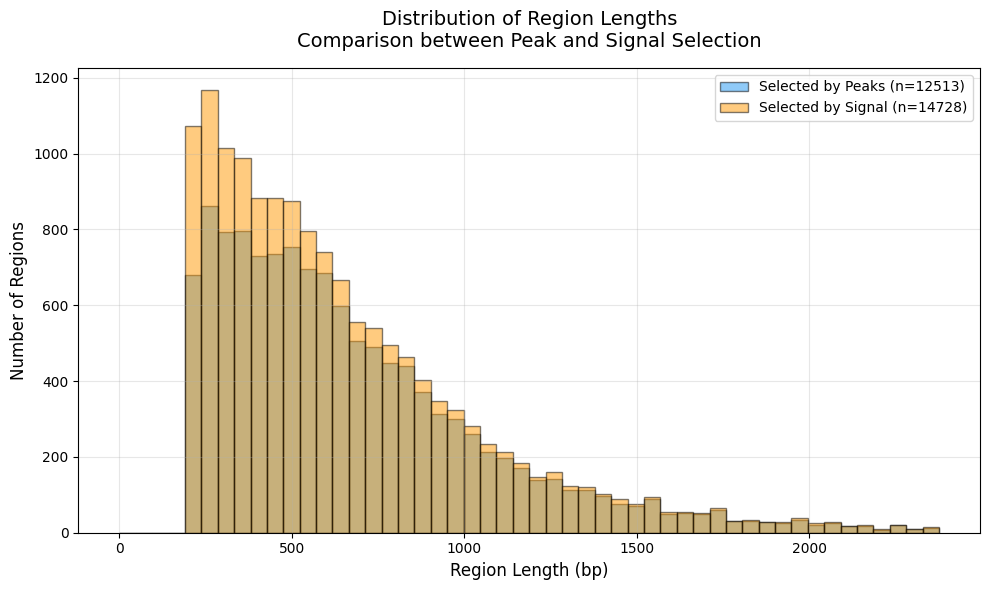

In [61]:
plot_region_length_comparison(both_df_by_peaks, both_df_by_signal, region_length_col='cpg_length')

In [62]:
both_df_sorted_by_cpg_length_peaks = both_df_by_peaks.sort_values(by='cpg_length', ascending=False)
both_df_sorted_by_cpg_length_peaks.head()
print_outlier_groups(both_df_sorted_by_cpg_length_peaks, "peaks")


First 5 outliers selected by peaks:
chr8:92,355,697-92,360,826                        enrichment: 1.4406701835396516
chr5:33,430,439-33,435,552                        enrichment: 1.2131558331281185
chrX:12,086,982-12,092,060                        enrichment: 2.2079998578848623
chrX:12,076,861-12,081,915                        enrichment: 2.0990726858277777
chr17:34,118,396-34,122,981                       enrichment: 5.6957625646668015

Middle 5 outliers selected by peaks:
chr8:94,386,178-94,386,763                        enrichment: 1.7827003158879489
chr5:35,574,601-35,575,186                        enrichment: 1.0537728347059547
chr9:57,130,733-57,131,318                        enrichment: 2.1705977158234853
chr6:120,916,390-120,916,975                      enrichment: 0.5827019645052118
chr5:135,488,854-135,489,439                      enrichment: 1.487835277631058

Last 5 outliers selected by peaks:
chr2:25,168,000-25,168,201                        enrichment: 0.8407437293363785

In [63]:
both_df_sorted_by_cpg_length_signal = both_df_by_signal.sort_values(by='cpg_length', ascending=False)
both_df_sorted_by_cpg_length_signal.head()
print_outlier_groups(both_df_sorted_by_cpg_length_signal, "signal")


First 5 outliers selected by signal:
chr8:92,355,697-92,360,826                        enrichment: 1.4406701835396516
chr5:33,430,439-33,435,552                        enrichment: 1.2131558331281185
chrX:12,086,982-12,092,060                        enrichment: 2.2079998578848623
chrX:12,076,861-12,081,915                        enrichment: 2.0990726858277777
chr17:34,118,396-34,122,981                       enrichment: 5.6957625646668015

Middle 5 outliers selected by signal:
chr8:11,497,356-11,497,908                        enrichment: 2.58101112864981
chr9:88,522,877-88,523,429                        enrichment: 7.728814167364319
chr15:81,925,826-81,926,377                       enrichment: 2.194736283511278
chr13:105,293,968-105,294,519                     enrichment: 1.1398008107321658
chr5:110,269,434-110,269,985                      enrichment: 0.6480032943276903

Last 5 outliers selected by signal:
chr7:29,024,054-29,024,255                        enrichment: 1.4941930101488392

# Neu only

In [64]:
neu_only_df_by_peaks.head()

,chr,start,end,neu_signal,nsc_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,neu_replicates_with_signal,nsc_replicates_with_signal,neu_replicate_signals,nsc_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,neu_replicates_with_peaks,nsc_replicates_with_peaks,neu_peak_scores_by_rep,nsc_peak_scores_by_rep,region_start,region_end
14866,chrX,169994005,169994235,56.443415,0.0,inf,1.0,neu_only,neu_only,False,3,0,"98.94648568937095,28.046897057259436,42.336861449893156","0.0,0.0,0.0",202,230,CpG:,1881,1,0,3.96491,NaN,169994044,169994246
14825,chrX,155305981,155306182,3.712136,0.0,inf,1.0,neu_only,neu_only,False,2,0,"10.323920989231453,0.8124869863733609,0.0","0.0,0.0,0.0",367,201,CpG:,1769,1,0,4.332,NaN,155305679,155306046
2101,chr11,74589731,74590417,19.634171,0.0,inf,1.0,neu_only,neu_only,False,3,0,"18.24205076959019,14.2874726976082,26.372988905664332","0.0,0.0,0.0",1397,686,CpG:,1154,1,0,3.74996,NaN,74589727,74591124
2013,chr11,69346555,69346800,7.745368,0.0,inf,1.0,neu_only,neu_only,False,2,0,"19.998821926116943,0.0,3.2372807612785928","0.0,0.0,0.0",260,245,CpG:,1114,1,0,4.98402,NaN,69346631,69346891
10455,chr5,106561167,106561519,14.387358,0.0,inf,1.0,neu_only,neu_only,False,3,0,"21.266713642047353,3.106070041656494,18.78929082286415","0.0,0.0,0.0",418,352,CpG:,1397,1,0,5.10912,NaN,106561100,106561518


In [65]:
# Generate summary statistics for numeric columns, ignoring inf values
# Replace inf values with NaN before calculating statistics
numeric_cols = ['neu_signal', 'nsc_signal', 'enrichment', 'region_length', 'cpg_length', 'pvalue']

stats_df = neu_only_df_by_peaks[numeric_cols].replace([np.inf, -np.inf], np.nan).describe()
print("neu only - by peaks, size:", len(neu_only_df_by_peaks))
stats_df

neu only - by peaks, size: 1379


,neu_signal,nsc_signal,enrichment,region_length,cpg_length,pvalue
count,1379.000000,1379.000000,1306.000000,1379.000000,1379.000000,1379.000000
mean,25.553079,12.272459,10.984888,1853.545323,522.224075,0.519676
std,26.079223,11.349193,88.107387,1524.798905,370.557174,0.342919
min,0.000000,0.000000,0.000000,201.000000,201.000000,0.100000
25%,10.943451,4.361811,1.100216,775.000000,271.000000,0.200000
50%,19.428094,9.702375,1.905373,1462.000000,402.000000,0.500000
75%,32.285449,16.764471,3.827857,2517.000000,628.500000,0.800000
max,406.881903,116.330976,2647.920164,13296.000000,2785.000000,1.000000


In [66]:
stats_df = neu_only_df_by_signal[numeric_cols].replace([np.inf, -np.inf], np.nan).describe()
print("neu only - by signal, size:", len(neu_only_df_by_signal))
stats_df

neu only - by signal, size: 128


,neu_signal,nsc_signal,enrichment,region_length,cpg_length,pvalue
count,128.000000,128.0,0.0,128.000000,128.000000,128.0
mean,14.698441,0.0,NaN,555.671875,516.921875,1.0
std,16.565639,0.0,NaN,398.714294,399.415313,0.0
min,0.348340,0.0,NaN,193.000000,201.000000,1.0
25%,4.693208,0.0,NaN,262.250000,280.500000,1.0
50%,9.341472,0.0,NaN,395.000000,366.500000,1.0
75%,18.654304,0.0,NaN,723.500000,571.250000,1.0
max,108.602980,0.0,NaN,2222.000000,2316.000000,1.0


In [67]:
print_across_distribution(neu_only_df_by_peaks, selection_type="peaks")


First 5 elements selected by peaks:
chrX:169,994,005-169,994,235                      enrichment: inf
chrX:155,305,981-155,306,182                      enrichment: inf
chr11:74,589,731-74,590,417                       enrichment: inf
chr11:69,346,555-69,346,800                       enrichment: inf
chr5:106,561,167-106,561,519                      enrichment: inf

Middle 5 elements selected by peaks:
chr2:157,020,678-157,021,147                      enrichment: 2.0740570675187904
chr11:54,303,909-54,304,468                       enrichment: 2.0739745570493104
chr1:89,968,235-89,968,791                        enrichment: 2.0705381566149006
chr16:28,564,357-28,565,093                       enrichment: 2.068395187134134
chr10:116,301,376-116,301,579                     enrichment: 2.054543643318784

Last 5 elements selected by peaks:
chr8:19,535,156-19,535,754                        enrichment: 0.0
chr4:3,230,990-3,231,230                          enrichment: 0.0
chr15:103,035,731-103,03

In [68]:
print_across_distribution(nsc_only_df_by_signal, selection_type="signal")


First 5 elements selected by signal:
chr7:14,622,325-14,623,100                        enrichment: 0.0
chr8:19,535,156-19,535,754                        enrichment: 0.0
chr8:20,122,209-20,122,868                        enrichment: 0.0
chrX:169,986,832-169,987,780                      enrichment: 0.0
chr8:20,296,932-20,297,602                        enrichment: 0.0

Middle 5 elements selected by signal:
chr4:3,230,990-3,231,230                          enrichment: 0.0
chr15:103,035,731-103,035,967                     enrichment: 0.0
chr17:36,161,661-36,162,048                       enrichment: 0.0
chr12:24,493,515-24,493,726                       enrichment: 0.0
chr7:49,636,312-49,636,892                        enrichment: 0.0

Last 5 elements selected by signal:
chr17:36,111,233-36,111,453                       enrichment: 0.0
chr17:36,110,763-36,110,967                       enrichment: 0.0
chr12:20,990,202-20,991,305                       enrichment: 0.0
chrX:75,723,624-75,723,957  

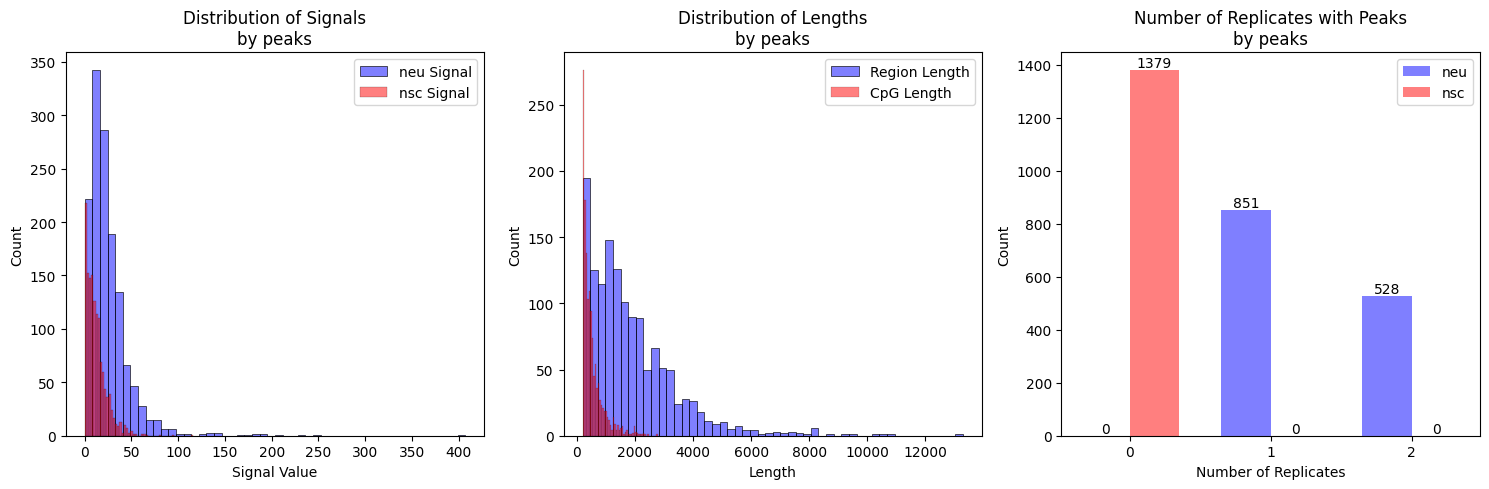

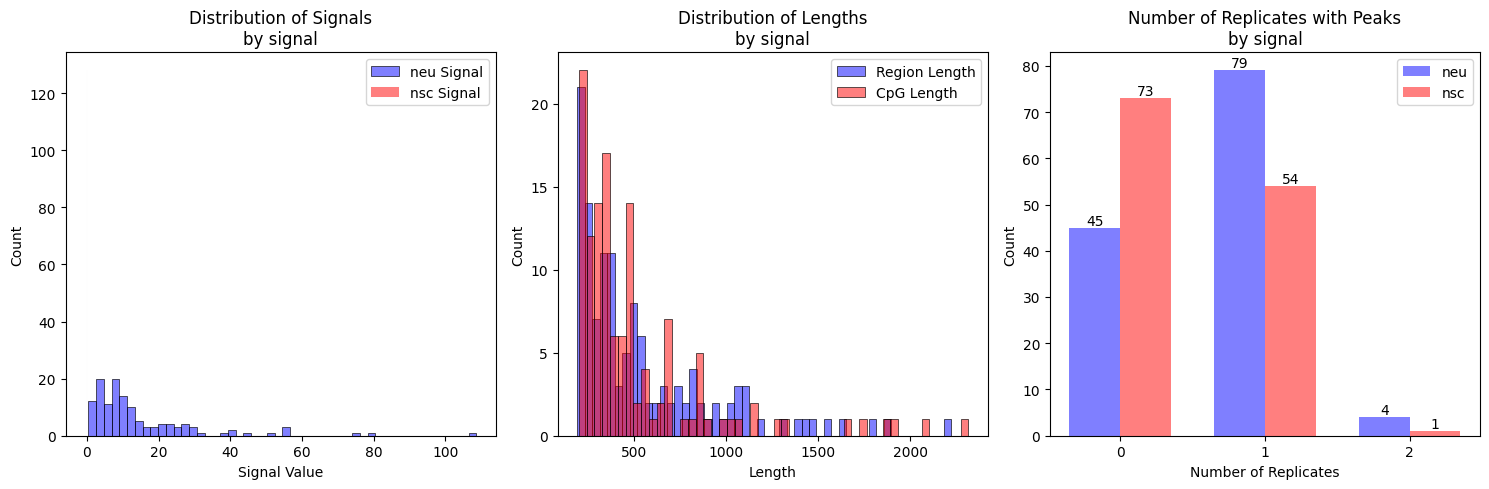

In [69]:
plot_neu_only_distributions(neu_only_df_by_peaks, title="by peaks")
plot_neu_only_distributions(neu_only_df_by_signal, title="by signal")

# NSC only

In [70]:
nsc_only_df_by_peaks.head()

,chr,start,end,neu_signal,nsc_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,neu_replicates_with_signal,nsc_replicates_with_signal,neu_replicate_signals,nsc_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,neu_replicates_with_peaks,nsc_replicates_with_peaks,neu_peak_scores_by_rep,nsc_peak_scores_by_rep,region_start,region_end
2145,chr11,76601278,76601611,2.984199,0.0,inf,1.0,neu_only,nsc_only,False,2,0,"3.1042127397912362,0.0,5.84838359970135","0.0,0.0,0.0",722,333,CpG:,1169,0,1,NaN,4.15678,76600916,76601638
5465,chr16,94079059,94079453,0.649920,0.0,inf,1.0,neu_only,nsc_only,False,1,0,"1.949759514863826,0.0,0.0","0.0,0.0,0.0",242,394,CpG:,1302,0,1,NaN,2.71094,94078920,94079162
5508,chr17,6256745,6257192,8.870128,0.0,inf,1.0,neu_only,nsc_only,False,2,0,"11.596917488403964,0.0,15.013467152913412","0.0,0.0,0.0",237,447,CpG:,632,0,1,NaN,6.59402,6257149,6257386
5575,chr17,23557751,23558165,9.969642,0.0,inf,1.0,neu_only,nsc_only,False,3,0,"11.727630577225616,5.942056462384652,12.239239526831586","0.0,0.0,0.0",276,414,CpG:,764,0,1,NaN,2.47276,23558046,23558322
13115,chr8,70743137,70743596,8.750214,0.0,inf,1.0,neu_only,nsc_only,False,2,0,"13.904421907710278,0.0,12.346221385039682","0.0,0.0,0.0",254,459,CpG:,1124,0,1,NaN,7.9521,70742883,70743137


In [71]:
# Generate summary statistics for numeric columns, ignoring inf values
# Replace inf values with NaN before calculating statistics
numeric_cols = ['neu_signal', 'nsc_signal', 'enrichment', 'region_length', 'cpg_length', 'pvalue']

stats_df = nsc_only_df_by_peaks[numeric_cols].replace([np.inf, -np.inf], np.nan).describe()
print("nsc only - by peaks, size:", len(nsc_only_df_by_peaks))
stats_df

nsc only - by peaks, size: 979


,neu_signal,nsc_signal,enrichment,region_length,cpg_length,pvalue
count,979.000000,979.000000,934.000000,979.000000,979.000000,979.000000
mean,18.996648,12.636123,4.745144,1864.511747,465.790603,0.578209
std,21.166099,11.480455,20.850120,1589.309743,335.678786,0.332028
min,0.000000,0.000000,0.000000,193.000000,201.000000,0.100000
25%,7.658998,4.425566,0.768094,813.000000,249.000000,0.200000
50%,13.843615,9.857877,1.432941,1425.000000,348.000000,0.666667
75%,22.848173,17.360708,2.711781,2420.000000,543.500000,1.000000
max,224.052105,83.431723,405.426103,12458.000000,3159.000000,1.000000


In [72]:
stats_df = nsc_only_df_by_signal[numeric_cols].replace([np.inf, -np.inf], np.nan).describe()
print("nsc only - by signal, size:", len(nsc_only_df_by_signal))
stats_df

nsc only - by signal, size: 15


,neu_signal,nsc_signal,enrichment,region_length,cpg_length,pvalue
count,15.0,15.000000,15.0,15.000000,15.000000,15.0
mean,0.0,7.824443,0.0,527.866667,547.933333,1.0
std,0.0,7.249105,0.0,338.955510,317.487338,0.0
min,0.0,0.131809,0.0,244.000000,204.000000,1.0
25%,0.0,2.469210,0.0,272.500000,238.000000,1.0
50%,0.0,5.022968,0.0,353.000000,580.000000,1.0
75%,0.0,11.509199,0.0,712.500000,722.500000,1.0
max,0.0,23.849362,0.0,1291.000000,1103.000000,1.0


In [73]:
print_across_distribution(nsc_only_df_by_peaks, selection_type="peaks")


First 5 elements selected by peaks:
chr11:76,601,278-76,601,611                       enrichment: inf
chr16:94,079,059-94,079,453                       enrichment: inf
chr17:6,256,745-6,257,192                         enrichment: inf
chr17:23,557,751-23,558,165                       enrichment: inf
chr8:70,743,137-70,743,596                        enrichment: inf

Middle 5 elements selected by peaks:
chr7:30,347,948-30,348,241                        enrichment: 1.510458038429525
chr7:45,679,084-45,679,307                        enrichment: 1.5067571415380028
chrX:8,206,309-8,206,720                          enrichment: 1.5041527781812691
chr12:86,244,152-86,244,456                       enrichment: 1.5040963754966072
chr4:136,880,487-136,880,738                      enrichment: 1.5012992805240424

Last 5 elements selected by peaks:
chr17:36,111,233-36,111,453                       enrichment: 0.0
chr17:36,110,763-36,110,967                       enrichment: 0.0
chr12:20,990,202-20,991

In [74]:
print_across_distribution(nsc_only_df_by_signal, selection_type="signal")


First 5 elements selected by signal:
chr7:14,622,325-14,623,100                        enrichment: 0.0
chr8:19,535,156-19,535,754                        enrichment: 0.0
chr8:20,122,209-20,122,868                        enrichment: 0.0
chrX:169,986,832-169,987,780                      enrichment: 0.0
chr8:20,296,932-20,297,602                        enrichment: 0.0

Middle 5 elements selected by signal:
chr4:3,230,990-3,231,230                          enrichment: 0.0
chr15:103,035,731-103,035,967                     enrichment: 0.0
chr17:36,161,661-36,162,048                       enrichment: 0.0
chr12:24,493,515-24,493,726                       enrichment: 0.0
chr7:49,636,312-49,636,892                        enrichment: 0.0

Last 5 elements selected by signal:
chr17:36,111,233-36,111,453                       enrichment: 0.0
chr17:36,110,763-36,110,967                       enrichment: 0.0
chr12:20,990,202-20,991,305                       enrichment: 0.0
chrX:75,723,624-75,723,957  

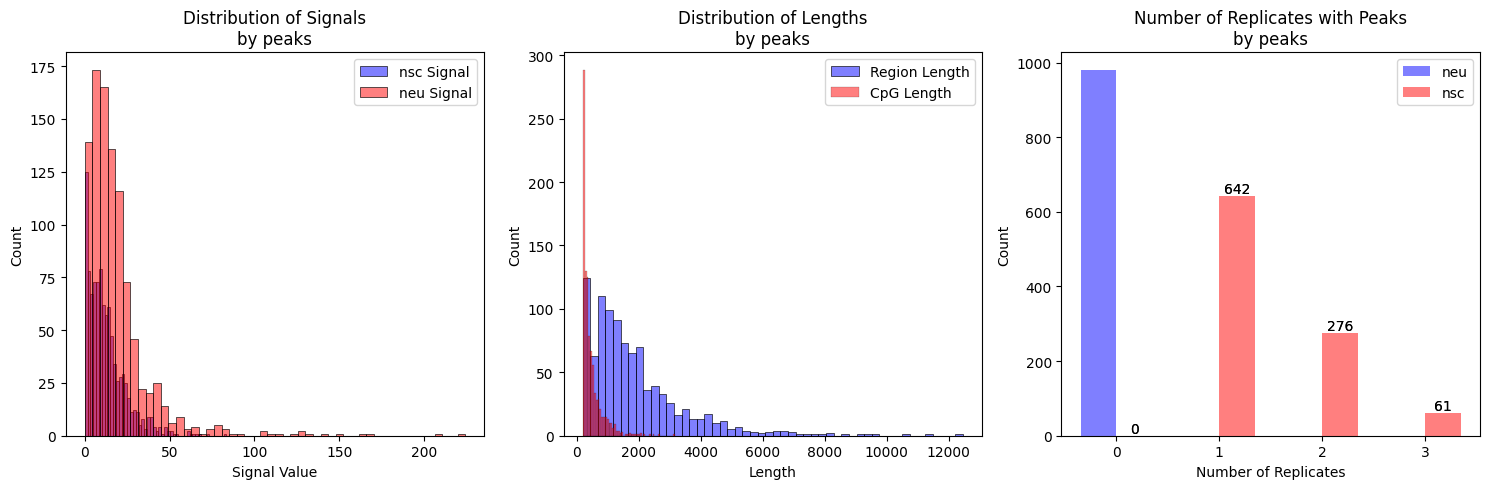

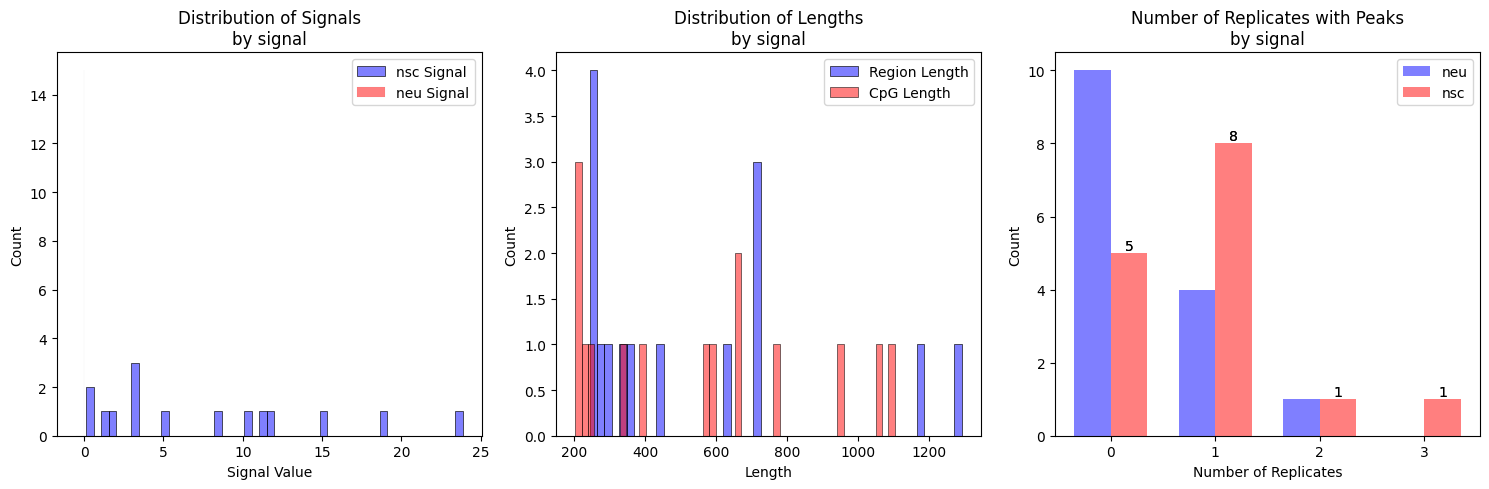

In [75]:
plot_nsc_only_distributions(nsc_only_df_by_peaks, title="by peaks")
plot_nsc_only_distributions(nsc_only_df_by_signal, title="by signal")

# Create output files

## UP in Neu

In [76]:
up_enriched_signal_1 = both_df_by_signal[(both_df_by_signal['enrichment'] > 1) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
up_enriched_signal_1_5 = both_df_by_signal[(both_df_by_signal['enrichment'] > 1.5) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()    
up_enriched_signal_2 = both_df_by_signal[(both_df_by_signal['enrichment'] > 2) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
# up_enriched_peaks_1 = both_df_by_peaks[(both_df_by_peaks['enrichment'] > 1) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()
# up_enriched_peaks_1_5 = both_df_by_peaks[(both_df_by_peaks['enrichment'] > 1.5) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()    
# up_enriched_peaks_2 = both_df_by_peaks[(both_df_by_peaks['enrichment'] > 2) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()

In [77]:
print("up_enriched_signal_1.shape:",   up_enriched_signal_1.shape)
print("up_enriched_signal_1_5.shape:", up_enriched_signal_1_5.shape)
print("up_enriched_signal_2.shape:",   up_enriched_signal_2.shape)
# print("up_enriched_peaks_1.shape:",    up_enriched_peaks_1.shape)
# print("up_enriched_peaks_1_5.shape:",  up_enriched_peaks_1_5.shape)
# print("up_enriched_peaks_2.shape:",    up_enriched_peaks_2.shape)

up_enriched_signal_1.shape: (11987, 24)
up_enriched_signal_1_5.shape: (8907, 24)
up_enriched_signal_2.shape: (6037, 24)


## UP in NSC

In [78]:
down_enriched_signal_1 = both_df_by_signal[(both_df_by_signal['enrichment'] < 1.0 ) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
down_enriched_signal_08 = both_df_by_signal[(both_df_by_signal['enrichment'] < 0.8 ) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
down_enriched_signal_05 = both_df_by_signal[(both_df_by_signal['enrichment'] < 0.5 ) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
# down_enriched_peaks_1 = both_df_by_peaks[(both_df_by_peaks['enrichment'] < 1.0) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()
# down_enriched_peaks_08 = both_df_by_peaks[(both_df_by_peaks['enrichment'] < 0.8) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()
# down_enriched_peaks_05 = both_df_by_peaks[(both_df_by_peaks['enrichment'] < 0.5) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()

In [79]:
print("down_enriched_signal_1.shape:",  down_enriched_signal_1.shape)
print("down_enriched_signal_08.shape:", down_enriched_signal_08.shape)
print("down_enriched_signal_05.shape:", down_enriched_signal_05.shape)
# print("down_enriched_peaks_1.shape:",   down_enriched_peaks_1.shape)
# print("down_enriched_peaks_08.shape:",  down_enriched_peaks_08.shape)
# print("down_enriched_peaks_05.shape:",  down_enriched_peaks_05.shape)

down_enriched_signal_1.shape: (2279, 24)
down_enriched_signal_08.shape: (1253, 24)
down_enriched_signal_05.shape: (361, 24)


## Save output files

In [80]:
up_enriched_signal_1.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_signal_1.csv', index=False)
up_enriched_signal_1_5.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_signal_1_5.csv', index=False)
up_enriched_signal_2.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_signal_2.csv', index=False)
# up_enriched_peaks_1.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_peaks_1.csv', index=False)
# up_enriched_peaks_1_5.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_peaks_1_5.csv', index=False)
# up_enriched_peaks_2.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_peaks_2.csv', index=False)

down_enriched_signal_1.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_signal_1.csv', index=False)
down_enriched_signal_08.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_signal_08.csv', index=False)
down_enriched_signal_05.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_signal_05.csv', index=False)
# down_enriched_peaks_1.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_peaks_1.csv', index=False)
# down_enriched_peaks_08.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_peaks_08.csv', index=False)
# down_enriched_peaks_05.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_peaks_05.csv', index=False)

neu_only_df_by_signal.to_csv(f'{OUTPUT_LISTS_PATH}/neu_only_df_by_signal.csv', index=False)
nsc_only_df_by_signal.to_csv(f'{OUTPUT_LISTS_PATH}/nsc_only_df_by_signal.csv', index=False)
neu_only_df_by_peaks.to_csv(f'{OUTPUT_LISTS_PATH}/neu_only_df_by_peaks.csv', index=False)
nsc_only_df_by_peaks.to_csv(f'{OUTPUT_LISTS_PATH}/nsc_only_df_by_peaks.csv', index=False)